# Orthogonal Chirps

These are just the include statements for whatever Python libraries we happen to need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
import pandas as pd
import pyaudio

plt.style.use('dark_background')

## Python Audio

The below function / framework is a helper used throughout this notebook for playing sounds. Sound cells will begin with a comment indicating that they play sound, and be separate from other code cells (audio will be their only function). Not all sounds will be audible, as there will be high frequencies outside of the human range of hearing.

In [2]:
def play_audio(data, player, fs, dev=None, vol=0.5):
    ostream = player.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    try:
        ostream.write(vol * data.astype(np.float32))
    except:
        print("an error has occured")
        
player = pyaudio.PyAudio()

## Orthogonal Chirps

These figures will be modelling those described in the paper "Orthogonal Chirp-Based Ultrasonic Positioning". The parameters listed below are the setup for the equation.

In [3]:
tc =  100e-3       # s
fn =  96e3        # Hz
fs =  15e3        # Hz
fh =  20e3        # Hz
ph =   0          # radians
B = fh - fs       # bandwith NOTE THE CORRECTION
mu = B / tc       # rate
M = 3             # number of transmitters

Now, it's time to simulate sampling, and we will end up with data similar to the below, assuming we sample at $f_n$.

In [4]:
n = np.arange(0, tc, 1/fn)
sn = np.exp(ph) * np.exp(2j * np.pi * ((fs * n) + (0.5 * mu * np.square(n))))

If you can't hear the chirp (played via the code below), you're not alone. Try increasing the chirp period (tc), or lowering the frequencies (fs and fh).

In [ ]:
# WARNING: SOUND
while True:
    play_audio(sn, player, fn)

C:\Users\Will\anaconda3\lib\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


The code below creates 3 plots of the chirp. The figure on the left shows the first tenth of the chirp (focusing on $f_s$, the starting frequency), the figure in the middle shows the entire chirp, and the figure on the right shows the last tenth of the chirp (focusing on $f_h$, the ending frequency).

C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


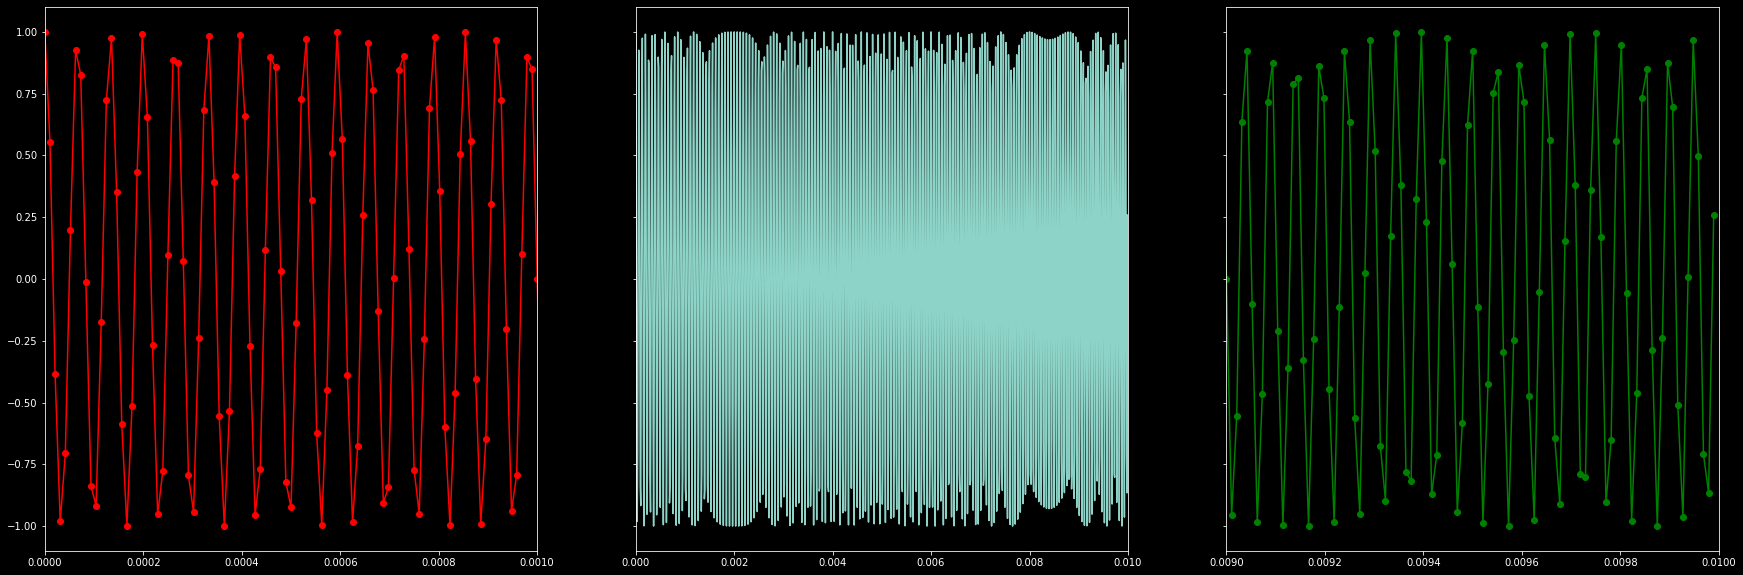

In [142]:
plt.rcParams["figure.figsize"] = (30, 10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)
ax1.plot(n, sn, 'ro-')
ax2.plot(n, sn)
ax3.plot(n, sn, 'go-')
ax1.set_xlim(0.000,0.001) #todo: hardcode bad
ax2.set_xlim(0.00,0.01)
ax3.set_xlim(0.009,0.010)
plt.show()

Now it's time to perform a DFT on our sampled data, and pad this with zeros, based on M.

In [143]:
Sn = sc.fft.fft(sn, int(fn * tc))  # DFT
Sz = np.zeros(len(Sn)) # zeros for padding

On = () # tuple of orthogonal chirps

Pn = [None] * M # temporary array used for Padding the chirps
for i in range(0, M):
    for j in range(0, M):
        if i == j:
            Pn[j] = Sn
        else:
            Pn[j] = Sz
    On += (np.vstack(Pn).T.flatten(),)
# print(On)

So now we have $M$ different $O_m[n]$ combinations (the result of padding $M-1$ zeros. From here, we can compute the autocorrelation, and crosscorrelation.

In [144]:
On_corrF = [None] * M**2 #correlations, calculated in frequency space, still in Fourier
for i in range(M):
    for j in range(M):
        On_corrF[M*i + j] = On[i] * np.conj(On[j])
ot_corrF = [sc.fft.ifft(F) for F in On_corrF] #correlations, calculated in frequency space, no longer in Fourier

Now that we've done this, we can plot the correlations.

C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\si

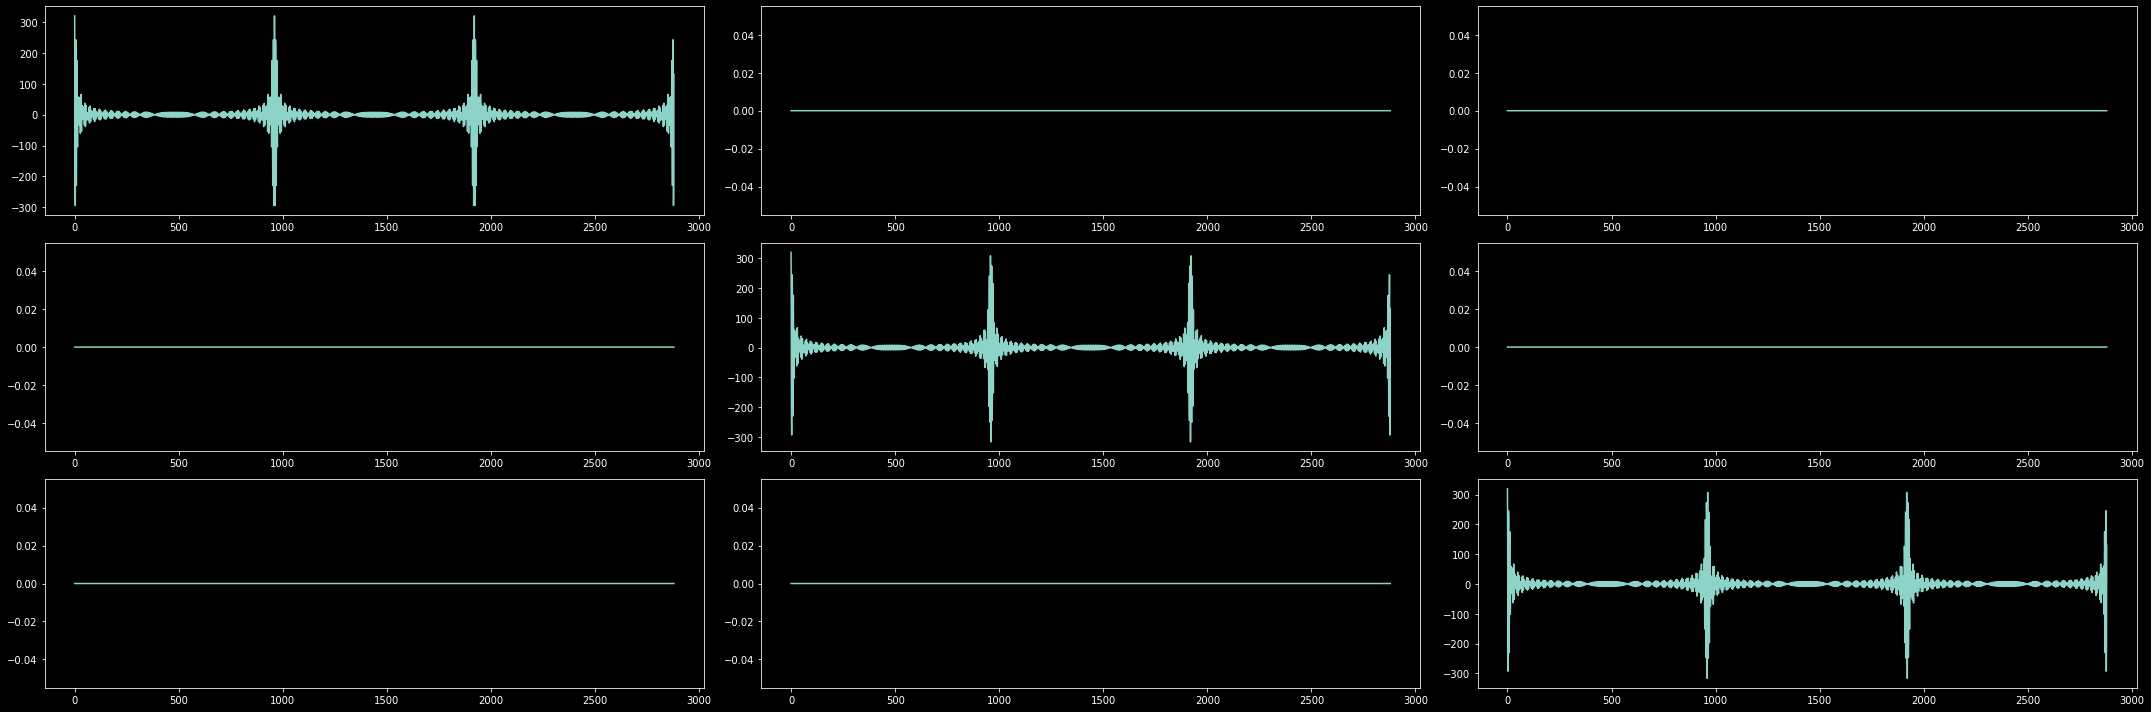

In [145]:
fig, axes = plt.subplots(nrows=M, ncols=M)

for i in range(M):
    for j in range(M):
        axes[i, j].plot(ot_corrF[i*M + j])
plt.tight_layout()
plt.show()

In [146]:
ot = [sc.fft.ifft(O) for O in On] #converting the padding back to time space

ot_corrT = [None] * M**2 #correlations, calculated in frequency space, still in Fourier
for i in range(M):
    for j in range(M):
        ot_corrT[M*i + j] = np.correlate(ot[i], ot[j], mode='full')

C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\si

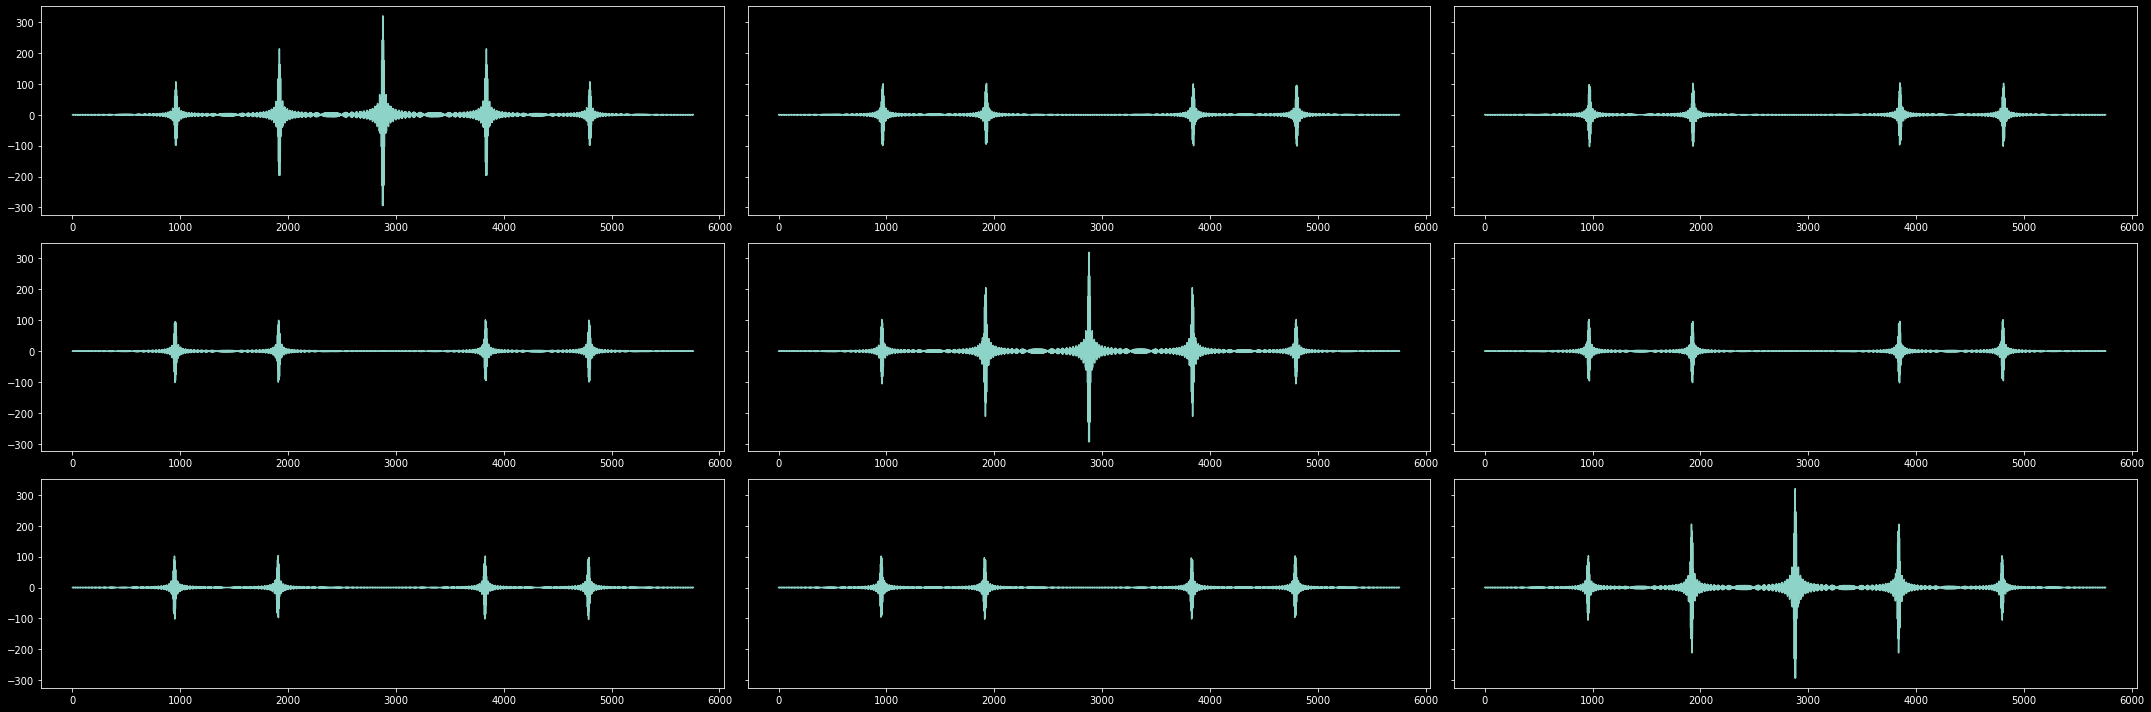

In [147]:
fig, axes = plt.subplots(nrows=M, ncols=M, sharey=True)

for i in range(M):
    for j in range(M):
        axes[i, j].plot(ot_corrT[i*M + j])
plt.tight_layout()
plt.show()